In [1]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *
import h5py

In [2]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_05_uvx.h5', 'r') as f:
    v = f['v'][:]
    u = f['u'][:]
    T = f['T'][:]
    x = f['x'][:]
    f.close()
N = T.shape[0]

In [3]:
def define_MSD(**kwargs_sys):
    # disc_x, disc_y = kwargs_sys['size'], kwargs_sys['size']
    dx, dy = kwargs_sys['spacing'], kwargs_sys['spacing']
    N_sys = kwargs_sys['N_sys']
    # padding = kwargs_sys['padding']

    def gen_params():
        
        return {key: value + value*np.random.uniform(-kwargs_sys['par_tol'], kwargs_sys['par_tol']) for key, value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    
    kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (dx * dy * 6)
    @jit
    def laplace(f):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel, mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    @jit
    def eom(y, t, params, iparams, exparams):
            
            par=params
            u=y['u']
            v=y['v']
            T=y['T']
            x=y['x']
            x_dot=y['x_dot']

            dudt = par['D']*laplace(u)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
            dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
            dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
            dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par)*0 - x_dot * par['c_damp'])
            dxdt = x_dot

            return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        x = ys['x']
        x_target = targets['x']
        x_dot = ys['x_dot']
        x_dot_target = targets['x_dot']
        return  jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#jnp.nanmean((u - u_target)**2) +
            
    return eom, loss, gen_params, gen_y0, {}

In [4]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,params = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
                             ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
                             'n_0','l_0','spacing'],mode = 'chaos')

keys =['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
        ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
        'n_0','l_0','spacing']
tol = 1
params_true = dict(zip(keys,params))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
#define grid and initial conditions
size = 100
pad = 10
delta_t_e = 0.08
sampling_rate = 10
length = 30#int(2000/sampling_rate)
t_evals = np.linspace(0, delta_t_e*sampling_rate*length, length)
u_fit = u[:length*sampling_rate][::sampling_rate,:,:]
T_fit = T[:length*sampling_rate][::sampling_rate,:,:]
v_fit = v[:length*sampling_rate][::sampling_rate,:,:]
x_fit = x[:length*sampling_rate][::sampling_rate,:,:,:]
x_dot = np.gradient(x,axis = 0)/delta_t_e
x_dot_fit = x_dot[:length*sampling_rate][::sampling_rate,:,:,:]
#select input state
u0 = u_fit[0]
v0 = v_fit[0]
T0 = T_fit[0]
x0 = x_fit[0]
x_dot0 = x_dot_fit[0]

kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3,'lower_b': params_low,'upper_b': params_high,
                   'lower_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0},
                    'upper_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0}}

In [5]:
# Setting up a dataset via simulation
Simulation_MSD = simple_simulation(define_MSD,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)
x_sim = Simulation_MSD.ys['x'][0]
x_dot_sim = Simulation_MSD.ys['x_dot'][0]
T_sim = Simulation_MSD.ys['T'][0]
u_sim = Simulation_MSD.ys['u'][0]
v_sim = Simulation_MSD.ys['v'][0]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
dA_sim = compute_dA(x_sim, 1)
dA_fit = compute_dA(x_fit, 1)
vmin,vmax =  -.2,.2

# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dA_fit[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"dA ground trouth")
    
    # Plot dA_sim
    im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"dA simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=x_sim.shape[0]-1, step=1, value=0, description="Frame")
# Display interactive plot
widgets.interactive(update_plot, frame=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=29), Output()), _dom_classes=('widget-intera…

In [ ]:
plt.close()

## Use Simulation data as ground trouth

In [7]:
x_sim = Simulation_MSD.ys['x'][0]
x_dot_sim = Simulation_MSD.ys['x_dot'][0]
T_sim = Simulation_MSD.ys['T'][0]
u_sim = Simulation_MSD.ys['u'][0]
v_sim = Simulation_MSD.ys['v'][0]

In [8]:
tol = 0.5
params_true = dict(zip(keys,params))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
print(params_low,params_high)

{'D': 0.11, 'a': 0.025, 'k': 4.0, 'epsilon_0': 0.001, 'mu_1': 0.1, 'mu_2': 0.15, 'k_T': 1.5, 'delta_t_e': 0.04, 'k_ij': 6.5, 'k_ij_pad': 11.5, 'k_j': 1.0, 'k_a': 4.5, 'k_a_pad': 11.5, 'c_a': 5.0, 'm': 0.5, 'c_damp': 7.5, 'n_0': 0.25, 'l_0': 0.5, 'spacing': 0.5} {'D': 0.33, 'a': 0.07500000000000001, 'k': 12.0, 'epsilon_0': 0.003, 'mu_1': 0.30000000000000004, 'mu_2': 0.44999999999999996, 'k_T': 4.5, 'delta_t_e': 0.12, 'k_ij': 19.5, 'k_ij_pad': 34.5, 'k_j': 3.0, 'k_a': 13.5, 'k_a_pad': 34.5, 'c_a': 15.0, 'm': 1.5, 'c_damp': 22.5, 'n_0': 0.75, 'l_0': 1.5, 'spacing': 1.5}


In [9]:
targets = {'u':u_sim.reshape(1,length,100,100),'v':v_sim.reshape(1,length,100,100),'T':T_sim.reshape(1,length,100,100),'x':x_sim.reshape(1,length,2,size+2*pad+1,size+2*pad+1),'x_dot':x_dot_sim.reshape(1,length,2,size+2*pad+1,size+2*pad+1)}
kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0.5,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 30,'N_backups': 1,'lr': 1e-2,'lower_b': params_low,'upper_b': params_high,
                   'lower_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0},
                    'upper_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0}}

In [ ]:
dataset_MSD = dataset_adoptODE(define_MSD,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)
_ = train_adoptODE(dataset_MSD)
print('Found params: ', dataset_MSD.params_train)

Epoch 000:  Loss: 1.1e-02,  Params Err.: 1.4e+01, y0 error: nan, Params Norm: 4.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 


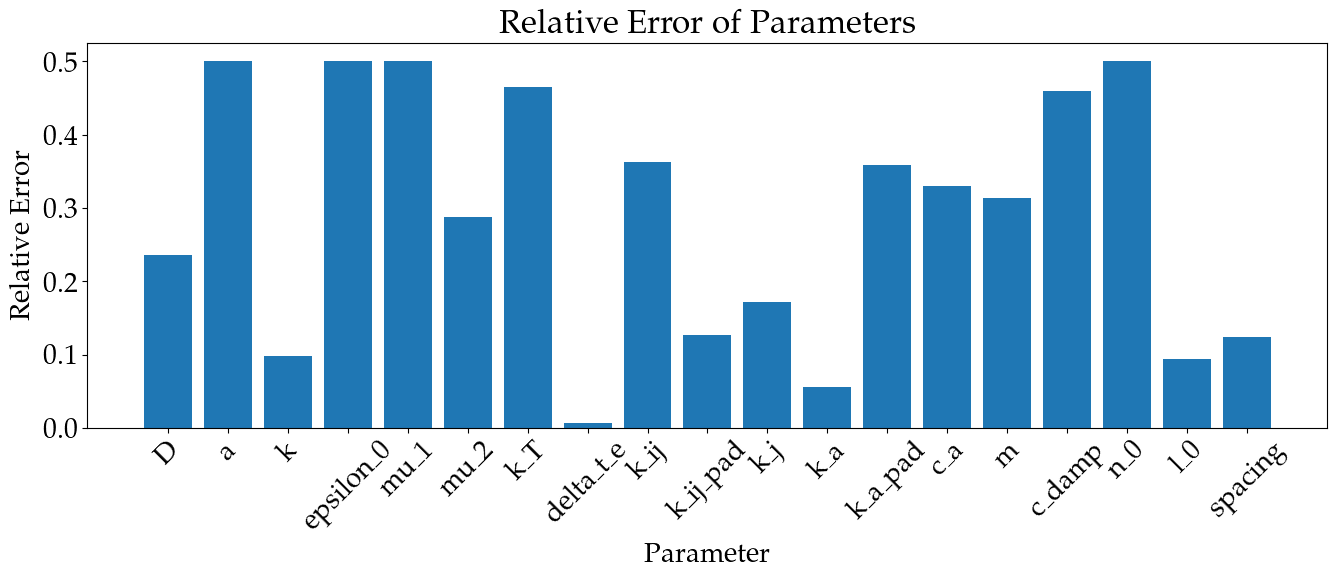

In [ ]:
# Get the parameter names
param_names = list(params_true.keys())
# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = params_true.get(param_name, np.nan)
    train_value = dataset_MSD.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 5))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [ ]:
x_rec = dataset_MSD.ys['x'][0]
x_dot_rec = dataset_MSD.ys['x_dot'][0]
T_rec = dataset_MSD.ys['T'][0]
u_rec = dataset_MSD.ys['u'][0]
v_rec = dataset_MSD.ys['v'][0]

In [ ]:
dA_rec = compute_dA(x_rec, 1)
dA_sim = compute_dA(x_sim, 1)
vmin,vmax =  -.2,.2

# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dA_fit[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"dA ground trouth")
    
    # Plot dA_sim
    im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"dA simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=x_sim.shape[0]-1, step=1, value=0, description="Frame")
# Display interactive plot
widgets.interactive(update_plot, frame=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=29), Output()), _dom_classes=('widget-intera…